RBTODO Python+X:

What is interpreted code?  versus compiled code?

Now that we have seen multicore parallelsim (OpenMP) a python patter is to:
  call from Python optimized code
  let's look at how big the benefit from compiled versus interpreted code
  * parallelims in Numpy??
  
  * 

In [ ]:
## Mutual Web Outlinks Example

Returning to our Web Outlinks example. Let's start with a review of 
  * building a small graph
  * building a larger graph 
  * the serial mutual outlinks program
  * a `joblib` parallelized outlinks program (based on processes)
  

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

G = nx.erdos_renyi_graph(5,0.8, directed=True)

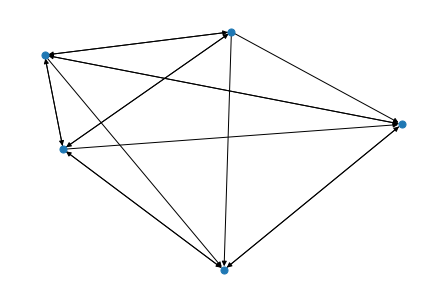

In [8]:
nx.draw(G, pos=nx.spring_layout(G), node_size=50)

In [9]:
gmat = nx.to_numpy_matrix(G)

outmat = np.zeros(gmat.shape)

for i in range(gmat.shape[0]):
    for j in range(i+1,gmat.shape[1]):        
        outmat[i,j] = np.dot(np.asarray(gmat[i,:]).reshape(-1), np.asarray(gmat[j,:]).reshape(-1))
outmat

array([[0., 3., 3., 2., 1.],
       [0., 0., 3., 2., 2.],
       [0., 0., 0., 1., 2.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

Now generate a big graph and we'll start our performance analysis. Let's look at a serial version on a graph with 1000 nodes and about 5 outbound edges per node. 

Serial program to calculate mutual outlinks.

10062

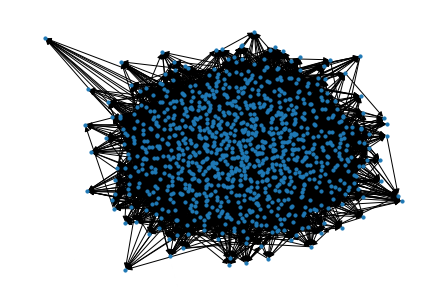

In [10]:
# cycles disappear when p = log(n)/n
G= nx.erdos_renyi_graph(1000,0.01,directed=True)
nx.draw(G, pos=nx.spring_layout(G), node_size=10)
G.number_of_edges()

In [11]:
import numpy as np

gmat = nx.to_numpy_matrix(G)

outmat = np.zeros(gmat.shape)

for i in range(gmat.shape[0]):
    for j in range(i+1,gmat.shape[1]):        
        outmat[i,j] = np.dot(np.asarray(gmat[i,:]).reshape(-1), np.asarray(gmat[j,:]).reshape(-1))
        
np.count_nonzero(outmat)

48161

In [12]:
%%timeit

outmat = np.zeros(gmat.shape)

for i in range(gmat.shape[0]):
    for j in range(i+1,gmat.shape[1]):        
        outmat[i,j] = np.dot(np.asarray(gmat[i,:]).reshape(-1), np.asarray(gmat[j,:]).reshape(-1))

4.65 s ± 81.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


So, now we have a serial implementation. Let's parallelize it.  It is always easiest to parallelize the outer loop.

In [7]:
%%timeit

def inner_loop(i):
    partial_out = np.zeros(gmat.shape[1])
    for j in range(i+1,gmat.shape[1]):    
        partial_out[j] = np.dot(np.asarray(gmat[i,:]).reshape(-1), np.asarray(gmat[j,:]).reshape(-1))    
    return partial_out
    
from joblib import Parallel, delayed
partials = Parallel(n_jobs=4)(delayed(inner_loop)(i) for i in range(gmat.shape[0]))

outmat = np.array(partials)
#np.count_nonzero(outmat)

3.32 s ± 349 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


A first idea is to "flatten" the inner loop. Remove the for loop by iterating all combinations of `i, j`. This could reduce interpreter overhead. For loops in interpreted languages are slow.

In [8]:
%%timeit

def row_and_row (i,j):
  return np.dot(np.asarray(gmat[i,:]).reshape(-1), np.asarray(gmat[j,:]).reshape(-1))

itertuples = list()

# define a generator function to enumerate all combinations of 2-rows
def gen_ij():
    for i in range(gmat.shape[0]):
        for j in range(i+1,gmat.shape[1]):
            yield (i,j)
    return
                
from joblib import Parallel, delayed
partials = Parallel(n_jobs=4)(delayed(row_and_row)(i,j) for (i,j) in gen_ij())

outmat = np.array(partials)
#np.count_nonzero(outmat)

4.78 s ± 714 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Compile the inner loop and see the effects.

In [14]:
%%timeit

from numba import jit

outmat = np.zeros(gmat.shape)

@jit(nopython=True)
def inner_loop(i):
    partial_out = np.zeros(gmat.shape[1])
    for j in range(i+1,gmat.shape[1]):    
        partial_out[j] = np.dot(np.asarray(gmat[i,:]).reshape(-1), np.asarray(gmat[j,:]).reshape(-1))  
    return partial_out
    
for i in range(gmat.shape[0]):
    outmat[i,:] = inner_loop(i)

np.count_nonzero(outmat)

232 ms ± 6.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


and parallelize the outer loop

In [15]:
%%timeit

from numba import jit, prange

@jit(nopython=True)
def inner_loop(i):
    partial_out = np.zeros(gmat.shape[1])
    for j in range(i+1,gmat.shape[1]):    
        partial_out[j] = np.dot(np.asarray(gmat[i,:]).reshape(-1), np.asarray(gmat[j,:]).reshape(-1))  
   # print(partial_out)
    return partial_out

# Gotta be in a function to parallize
@jit(nopython=True)    
def outerloop():
    outmat = np.zeros(gmat.shape)

    for i in prange(gmat.shape[0]):
        outmat[i,:] = inner_loop(i)

    #print(outmat)
    np.count_nonzero(outmat)

91.1 µs ± 1.64 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


<AxesSubplot:>

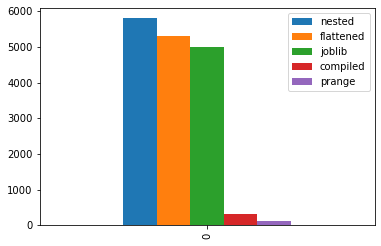

In [13]:
import pandas as pd

# get values from code
d = { 'nested': [5800], 'flattened': [5310], 'joblib': [5000], 'compiled': [319], 'prange': [114] }

df = pd.DataFrame (data=d)
df.head()
df.plot.bar()

From here, we should do a study of the parameters of 

*Q1* Loops.  NUmba documentation says

```Whilst NumPy has developed a strong idiom around the use of vector operations, 
Numba is perfectly happy with loops too. For users familiar with C or Fortran, 
writing Python in this style will work fine in Numba (after all, LLVM gets a lot 
of use in compiling C lineage languages). For example:```

In [15]:
from numba import njit

@njit(parallel=False)
def ident_np(x):
    return np.cos(x) ** 2 + np.sin(x) ** 2

@njit(parallel=False)
def ident_loops(x):
    r = np.empty_like(x)
    n = len(x)
    for i in range(n):
        r[i] = np.cos(x[i]) ** 2 + np.sin(x[i]) ** 2
    return r

a = np.random.rand(100000,1)

%timeit ident_np(a)
%timeit ident_loops(a)


1.85 ms ± 45.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
9.86 ms ± 444 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Hmmm. That seems not to be true. Probably a function of vectorization or potentially parallelization inside np.